## Connect to CDF

In [56]:
import os
import sys
import pandas as pd
import numpy as np
from cognite.client.data_classes import TimeSeries, Sequence
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
module_path = os.path.abspath(os.path.join("../utils"))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/kevin.peng/code/cognite/Drilling-rate-of-penetration-prediction/utils


In [3]:
from pathlib import Path
from dotenv import load_dotenv
dotenv_path = Path("../utils/.env")
load_dotenv(dotenv_path=dotenv_path)
CLIENT_SECRET = os.getenv("CLIENT_SECRET")  # store secret in .env file
print("CLIENT_SECRET")
print(CLIENT_SECRET)

CLIENT_SECRET
b2kwbWhqI09ZeiFVeURzWQ==


In [4]:
import auth as cauth
c = cauth.create_cognite_client('client-secret')

CLIENT_SECRET
b2kwbWhqI09ZeiFVeURzWQ==


In [5]:
c.login.status()

/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_32901/2034473358.py:1: UserWarning: It seems you are trying to reach API endpoint `/login/status` which is only valid when authenticating using an API key - without an API key. Try `client.iam.token.inspect` instead
  c.login.status()


{
    "user": "31c71712-7dad-45dd-936b-871bd198c63c",
    "project": "",
    "project_id": -1,
    "logged_in": true
}

## Create asset hierarchy

In [6]:
c.data_sets.retrieve(external_id="rop_wells")

,value
external_id,rop_wells
name,rop_wells
write_protected,False
id,7121227008062499
created_time,1676499933747
last_updated_time,1676499933747


In [7]:
dataset_id =c.data_sets.retrieve(external_id="rop_wells").id
dataset_id

7121227008062499

In [8]:
from cognite.client.data_classes import Asset

# Create Root Asset
root_asset = c.assets.create(Asset(name='rop_sensors_model', external_id='rop_sensors_model',data_set_id=dataset_id))
root_asset

,value
external_id,rop_sensors_model
name,rop_sensors_model
data_set_id,7121227008062499
id,1241809692811950
created_time,1676910778737
last_updated_time,1676910778737
root_id,1241809692811950


In [9]:
root_asset_obj = c.assets.retrieve(id =1241809692811950)
root_asset_obj

,value
external_id,rop_sensors_model
name,rop_sensors_model
data_set_id,7121227008062499
id,1241809692811950
created_time,1676910778737
last_updated_time,1676910778737
root_id,1241809692811950


In [19]:
function_external_id = "well8532_function-master"
function_obj = c.functions.retrieve(external_id="well8532_function-master")

In [20]:
data_for_func= {"external_id":"well5832_sequence", "start":0, "end":-1}

call = function_obj.call(data=data_for_func)
call

,value
id,2573492331849606
start_time,1676912923469
end_time,1676912928119
status,Completed
function_id,7512202405982391


In [13]:
df = c.sequences.data.retrieve_dataframe(external_id="well5832_sequence",start=0,end=-1)

In [18]:
model_df = df[['Depth(m)', 'ROP(1 m)']]

In [22]:
model_df = model_df.assign(prediction=call.get_response())

In [23]:
model_df

,Depth(m),ROP(1 m),prediction
1,25.96,17.31,65.9638
2,26.27,18.63,65.9638
3,26.59,5.66,116.6667
4,26.90,11.67,138.3851
5,27.24,120.20,129.5890
...,...,...,...
7307,2295.71,3.29,3.5837
7308,2296.01,4.12,3.9735
7309,2296.32,3.85,3.8493
7310,2296.63,4.49,4.2334


In [33]:
# Create each sensor as a new asset
store = []
for model in model_df.columns:
    asset=Asset(name=model, external_id =model+'_model_ext_id',data_set_id=dataset_id,parent_id=root_asset_obj.id)
    store.append(asset)

c.assets.create(store)

,external_id,name,parent_id,data_set_id,metadata,id,created_time,last_updated_time,root_id
0,Depth(m)_model_ext_id,Depth(m),1241809692811950,7121227008062499,{},4521984162286985,1676913589240,1676913589240,1241809692811950
1,ROP(1 m)_model_ext_id,ROP(1 m),1241809692811950,7121227008062499,{},7409357438442620,1676913589240,1676913589240,1241809692811950
2,prediction_model_ext_id,prediction,1241809692811950,7121227008062499,{},5689768599383520,1676913589240,1676913589240,1241809692811950


In [34]:
col_def = []
for col in model_df.columns:
    col_def.append({"valueType":"DOUBLE","externalId":f"{col}","description":f"some description for asset {col}_model_ext_id"})

In [35]:
len(col_def)

3

In [36]:
seq = c.sequences.create(Sequence(external_id="well5832_sequence_model",name="well5832_sequence_model", columns=col_def,data_set_id=dataset_id ))

In [37]:
seq

,value
id,1313227858623252
name,well5832_sequence_model
external_id,well5832_sequence_model
columns,"[{'externalId': 'Depth(m)', 'description': 'so..."
created_time,1676913911960
last_updated_time,1676913911960
data_set_id,7121227008062499


## insert datapoints

In [38]:
import copy
df = copy.deepcopy(model_df)
print(df.shape)
df.head()

(7311, 3)


,Depth(m),ROP(1 m),prediction
1,25.96,17.31,65.9638
2,26.27,18.63,65.9638
3,26.59,5.66,116.6667
4,26.90,11.67,138.3851
5,27.24,120.20,129.5890


In [39]:
res = c.sequences.retrieve(id=1313227858623252)

In [40]:
column_external_ids = [ r['externalId'] for r in c.sequences.retrieve(id=1313227858623252).columns]

In [44]:
column_external_ids

['Depth(m)', 'ROP(1 m)', 'prediction']

In [41]:
res

,value
id,1313227858623252
name,well5832_sequence_model
external_id,well5832_sequence_model
columns,"[{'externalId': 'Depth(m)', 'description': 'so..."
created_time,1676913911960
last_updated_time,1676913911960
data_set_id,7121227008062499


In [42]:
df

,Depth(m),ROP(1 m),prediction
1,25.96,17.31,65.9638
2,26.27,18.63,65.9638
3,26.59,5.66,116.6667
4,26.90,11.67,138.3851
5,27.24,120.20,129.5890
...,...,...,...
7307,2295.71,3.29,3.5837
7308,2296.01,4.12,3.9735
7309,2296.32,3.85,3.8493
7310,2296.63,4.49,4.2334


In [43]:

    
dataList = [] #empty list
for index, row in df.iterrows():
    temp_row=[]
    for col in column_external_ids:
        temp_row.append(row[col])
    dataList.append((index+1, temp_row))
    

In [45]:
c.sequences.data.insert(column_external_ids=column_external_ids, rows=dataList, id=1313227858623252)

In [52]:
data_plot = c.sequences.data.retrieve_dataframe(external_id="well5832_sequence_model",start=0,end=-1)

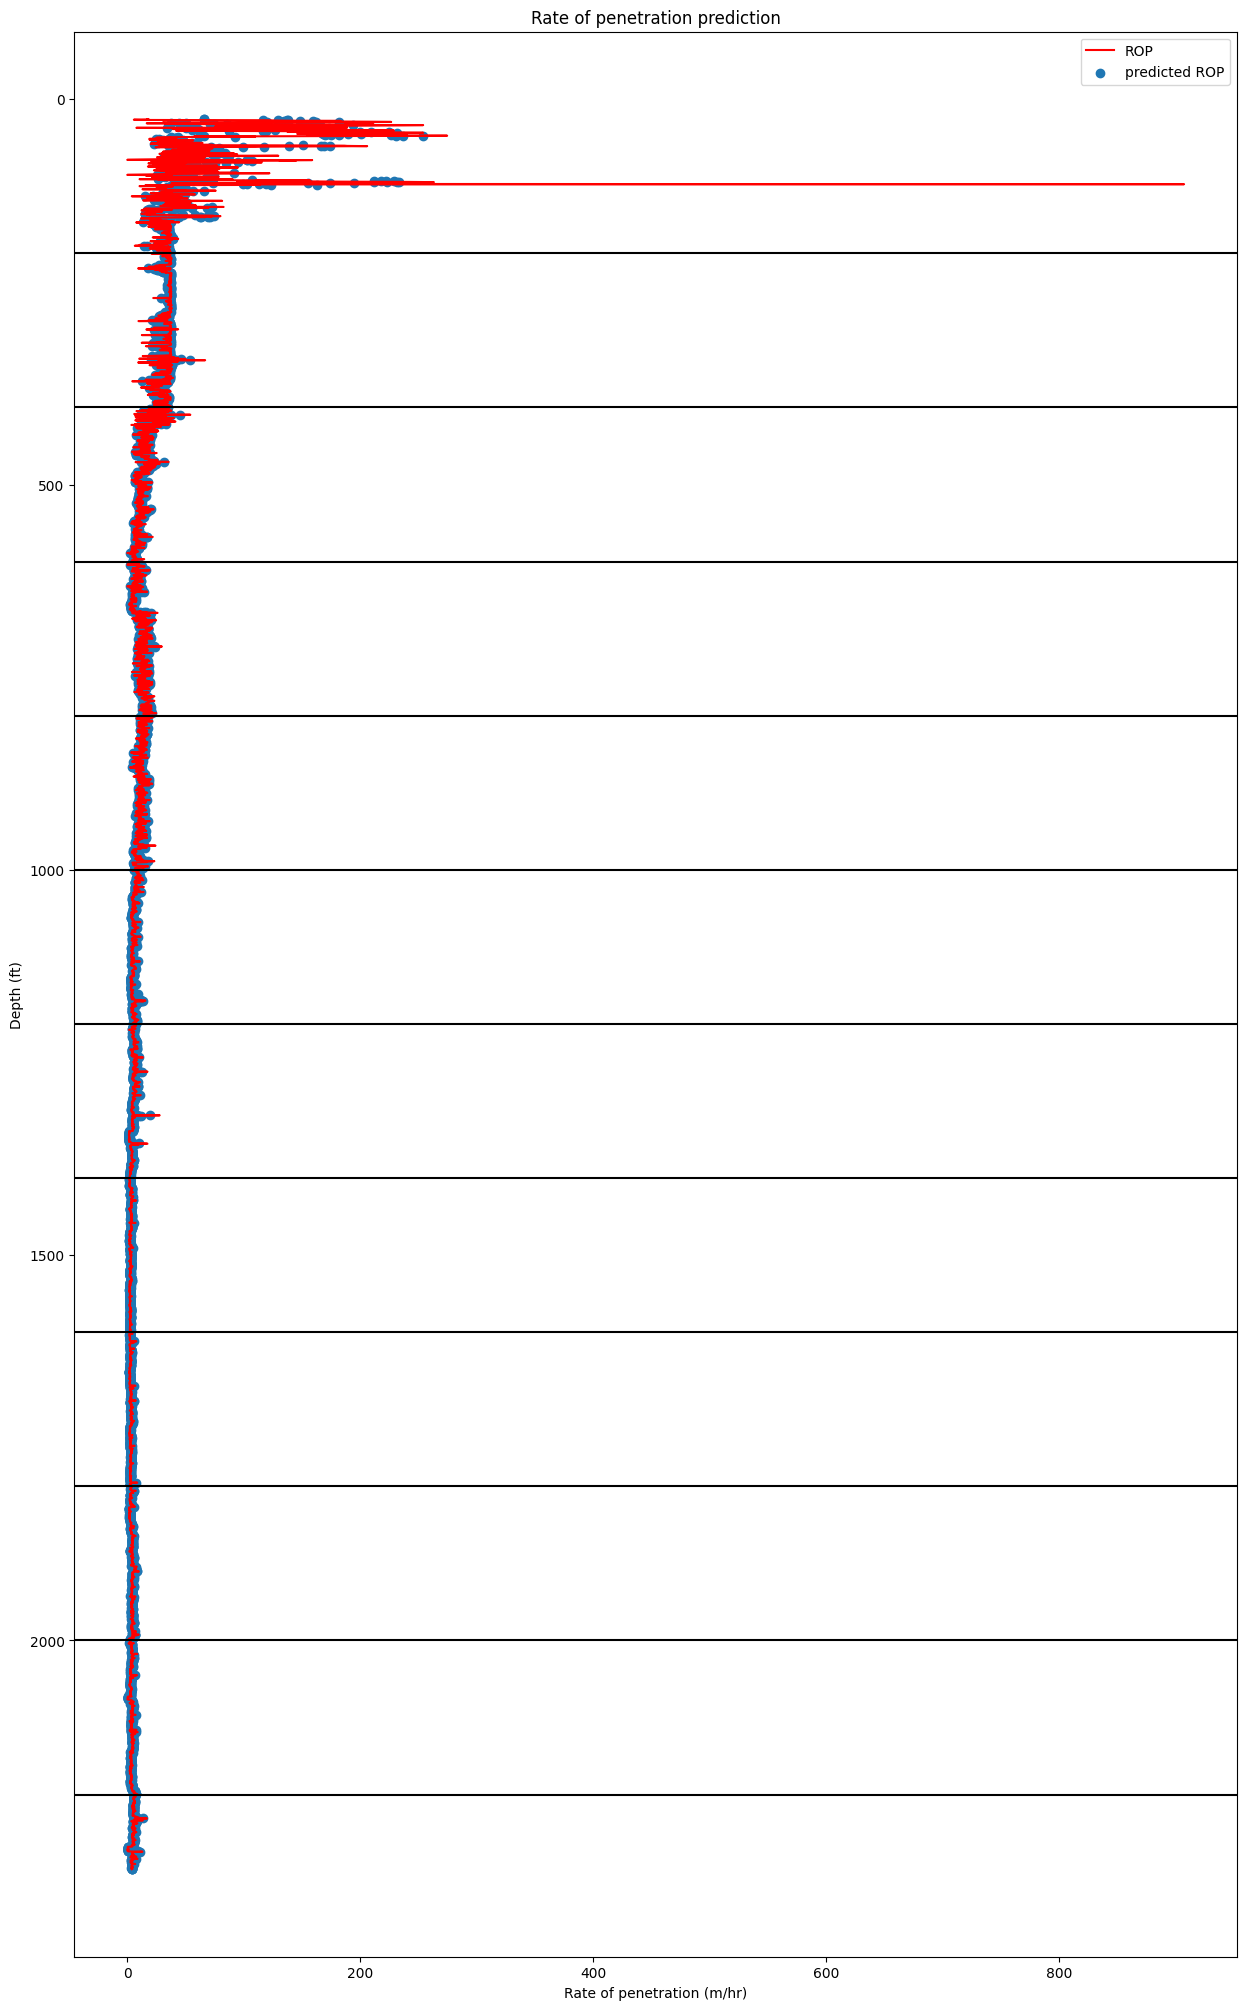

In [57]:
fig,ax=plt.subplots(figsize=(15,25))
ax.plot(data_plot['ROP(1 m)'].values.reshape(-1,1),data_plot['Depth(m)'].values.reshape(-1,1),'r',label='ROP')
ax.scatter(data_plot['prediction'].values.reshape(-1,1),data_plot['Depth(m)'].values.reshape(-1,1),label='predicted ROP')
ay=plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)')
plt.xlabel('Rate of penetration (m/hr)')
plt.title('Rate of penetration prediction');
plt.legend(loc="best")
depth=[depth for depth in range(200,2400,200) ]
for i in range(len(depth)):
    plt.axhline(depth[i],color='black' )